# Dimensionality Reduction: Linear and Nonlinear Approaches

<center> Author: Faisal Jayousi </center>

<center> Date: February 2024   </center>


**Abstract** This notebook explores PCA and its kernelised version, two dimensionality reduction techniques that commonly used nowadays. Using the moons dataset as an example, we demonstrate how kPCA captures complex, non-linear structures that PCA cannot. The implementation is validated by comaring the results with scikit-learn's `PCA` and `KernelPCA`.

## Table of Contents

- [Dimensionality Reduction: Linear and Nonlinear Approaches](#dimensionality-reduction:-linear-and-nonlinear-approaches)
  - [Principal Component Analysis](#principal-component-analysis)
    - [Manual PCA](#manual-pca)
    - [PCA using scikit-learn](#pca-using-scikit-learn)
  - [Kernel Principal Component Analysis](#kernel-principal-component-analysis)
    - [Manual kPCA](#manual-kpca)
    - [kPCA using scikit-learn](#kpca-using-scikit-learn)


## Principal Component Analysis

Let $X=(\boldsymbol{x}_1,\cdots,\boldsymbol{x}_m)\in\mathbb{R}^{n\times m}$ be a centered design matrix where each column $x_i$ represents a data point. More specifically, $n$ is the number of features for each data point, and $m$ is the number of data points. Each column $\boldsymbol{x}_i\in\mathbb{R}^n$ represents a single data point with $n$ features. The goal is goal is to reduce the dimensionality from $n$ features to $k$ features $(k\ll n)$.

In PCA, the data is projected on the $k$-dimensional vector space that minimises the error between the original data and the projected data. This amounts to finiding an orthogonal projection matrix $\Pi$ ($\Pi^T=\Pi$) of rank $k$ such that $\|\Pi X-X\|_F^2$ is minimised. The optimisation problem writes $$\min_{\substack{\Pi \\ \operatorname{rank}(\Pi) = k}} \|\Pi X - X\|_F^2$$

**Proposition** The solution of the optimisation problem is given by $\Pi^*=U_kU_k^T$ where $U_k\in\mathbb{R}^{n\times k}$ is the matrix formed by the top $k$ singular vectors of the empirical covariance matrix $\Sigma=\frac{1}{m}XX^T$.

PCA thus operates on the covariance matrix $\Sigma=\frac{1}{m}XX^T\in\mathbb{R}^{n\times n}$. To reduce the dimensionality of $X$ while preserving the maximum variance, one has to:

1. Center the data: $X_c=X-\overline{X}$ where $\overline{X}$ is the matrix of column means.
2. Compute the covariance matrix $\Sigma=\frac{1}{m}X_cX_c^T$. This matrix captures the pairwise covariances between the features.
3. Perform eigenvalue decomposition on $\Sigma:=UDU^T$ where $U\in\mathbb{R}^{n\times n}$ is the matrix of eigenvectors (aka principal components) and $D$ is the diagonal matrix containing the eigenvalues of $\Sigma$.
4. Select the $k$ eigenvectors corresponding to the largest $k$ eigenvalues $(U_k)$. These eigenvectors define the $k$-dimensional subspace that captures the most variance in the data.
5. Transform the data by projecting it on the selected components: $U_k^TX_c$.


In [1]:
# Import modules
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA

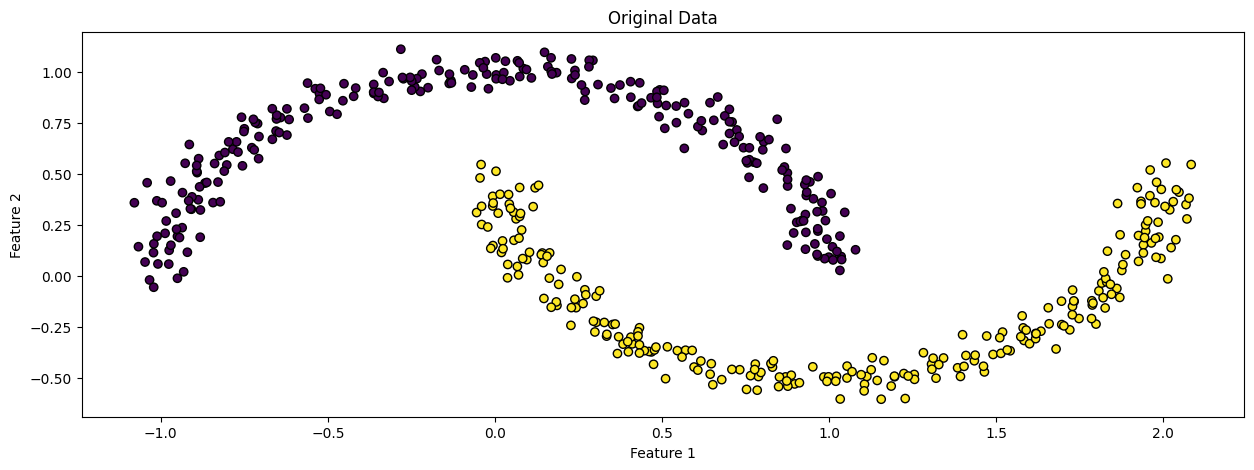

In [2]:
# Import data
data = np.loadtxt(Path("..") / "data" / "moons.txt", delimiter=",", skiprows=1)
X = np.transpose(data[:, :2])  # design matrix (n_features, n_samples)
y = data[:, 2]  # labels


# Plot
plt.figure(figsize=(15, 5))
plt.scatter(X[0], X[1], c=y, cmap='viridis', edgecolor='k')
plt.title("Original Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Manual PCA


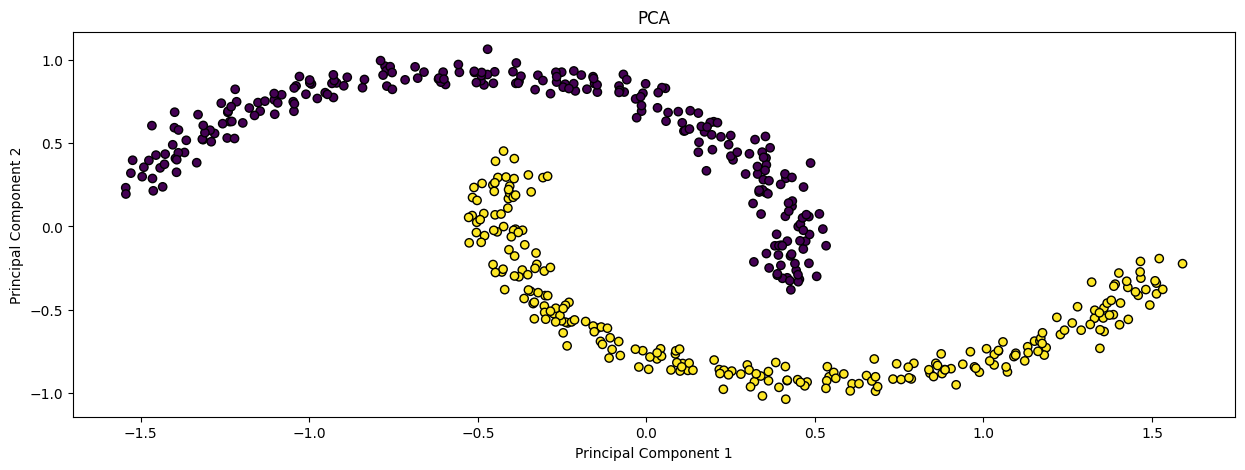

In [3]:
# PCA
n_components = 2  # k

# Step 1: Center the data
Xc = X - X.mean(axis=1, keepdims=True)

# Step 2: Compute the covariance matrix
covariance_matrix = (Xc @ Xc.T) / len(y)
# Sigma = np.cov(Xc, rowvar=True, bias=True)  # another possible way

# Step 3: Perform eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

# Step 4a: Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Step 4b: Select the top k eigenvectors (principal components)
components = sorted_eigenvectors[:, :n_components]

# Step 5: Transform the data
Y = np.dot(components, Xc)

# Plot
plt.figure(figsize=(15, 5))
plt.scatter(-Y[0], -Y[1], c=y, cmap='viridis', edgecolor='k')
plt.title("PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### PCA using scikit-learn


Eigenvalues (Manual): [0.82018509 0.18331665]
Eigenvalues (Scikit-learn): [0.82182874 0.18368401]
Eigenvectors (Manual): [[-0.94783013 -0.31877586]
 [ 0.31877586 -0.94783013]]
Eigenvectors (Scikit-learn): [[ 0.94783013 -0.31877586]
 [ 0.31877586  0.94783013]]


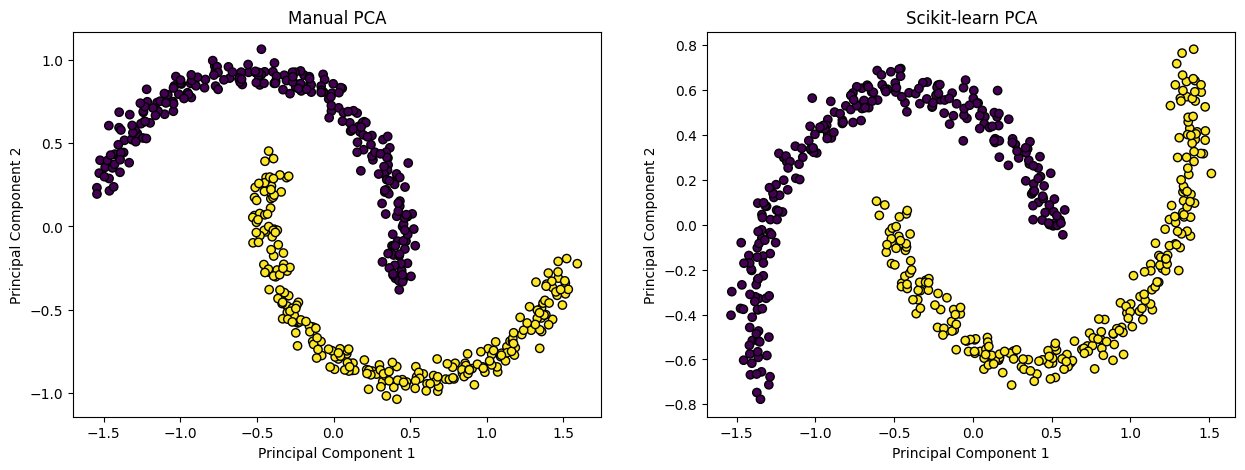

In [4]:
# Comparing with scikit-learn's output
pca = PCA(n_components=n_components)

# scikit-learn expects samples to be in rows, so we transpose X
Y_sklearn = pca.fit_transform(X.T)

# Eigenvalues / eigenvectors from scikit-learn
eigenvalues_sklearn = pca.explained_variance_
eigenvectors_sklearn = pca.components_

print("Eigenvalues (Manual):", sorted_eigenvalues)
print("Eigenvalues (Scikit-learn):", eigenvalues_sklearn)

print("Eigenvectors (Manual):", components)
print("Eigenvectors (Scikit-learn):", eigenvectors_sklearn)

# Plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(-Y[0], -Y[1], c=y, cmap='viridis', edgecolor='k')
plt.title("Manual PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.subplot(1, 2, 2)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],
            c=y, cmap='viridis', edgecolor='k')
plt.title("Scikit-learn PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## Kernel Principal Component Analysis


As seen above, PCA is not at all informative when it comes to data with non-linear structure. This is expected since PCA projects the data onto linear components. We consider now the kernelised version of PCA. Let $\varphi$ be a feature map to an arbitrary RKHS $\mathcal{H}$ (possibly infinite-dimensional), and let $K\colon\mathbb{R}^n\times\mathbb{R}^n\to\mathbb{R}$ be a positive definite symmetric kernel such that $K(x_i,x_j)=\langle\varphi(x_i),\varphi(x_j)\rangle_{\mathcal{H}}$. The kernel matrix $K_X$ is defined as $K_X = X^TX$.

**Proposition** The singular vector $u$ of $\Sigma$ associated to the singular value $\lambda/m$ coincides with $Xv/\lambda$ where $v$ is the singular vector of $K_X$ associated to $\lambda$.

**Corollary** Let $\varphi(x)\in\mathcal{H}$ be an arbitrary feature vector. Then $$\langle\varphi(x),u\rangle_{\mathcal{H}} = \frac{1}{\sqrt{\lambda}}k_x^Tv$$ where $k_x=(K(x_1,x),\dots,K(x_m,x))^T$. In particular, if $x=x_i$ for some $i$, then $$\langle\varphi(x),u\rangle_{\mathcal{H}}= \sqrt{\lambda}v_i$$

Kernel PCA thus operates on the kernel matrix. To reduce the dimensionality of a dataset $X$, one has to:

1. Choose an appropriate kernel to compute the pairwise similarities.
2. Compute and center the kernel matrix $K_X$ (in the feature space!).
3. Compute the eigenvalues and eigenvectors of the centered kernel matrix.
4. Select the top $k$ eigenvectors associated to the highest $k$ eigenvalues.
5. Project the centered kernel matrix onto the selected eigenvectors to obtain the transformed data.


### Manual kPCA


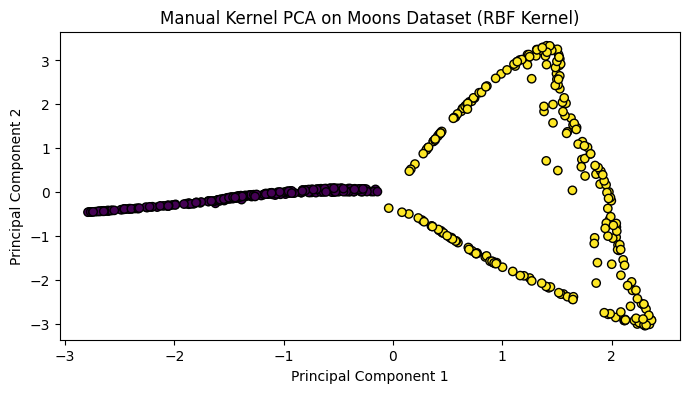

In [5]:
# Step 1: Define kernel (Gaussian kernel)
def gauss_kernel(X, gamma=15):
    squared_norms = np.sum(X**2, axis=0)  # (n_samples,)

    # Compute the pairwise squared Euclidean distances using:
    # ||x - y||^2 = ||x||^2 + ||y||^2 - 2*x.y
    sq_dists = squared_norms[np.newaxis, :] + squared_norms[:,
                                                            # (n_samples, n_samples)
                                                            np.newaxis] - 2 * np.dot(X.T, X)
    return np.exp(-gamma * sq_dists)


# Step 2: Compute and center K_X
K = gauss_kernel(X)
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_c = K - np.dot(one_n, K) - np.dot(K, one_n) + np.dot(one_n, np.dot(K, one_n))

# Step 3: Compute eigenvalues / eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(K_c)

# Step 4: Select the top k eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
top_eigenvectors = eigenvectors[:, :n_components]

# Step 5: Projection
Y_kpca = np.dot(K_c, top_eigenvectors)

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(Y_kpca[:, 0], Y_kpca[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title("Manual Kernel PCA on Moons Dataset (RBF Kernel)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### kPCA using scikit-learn


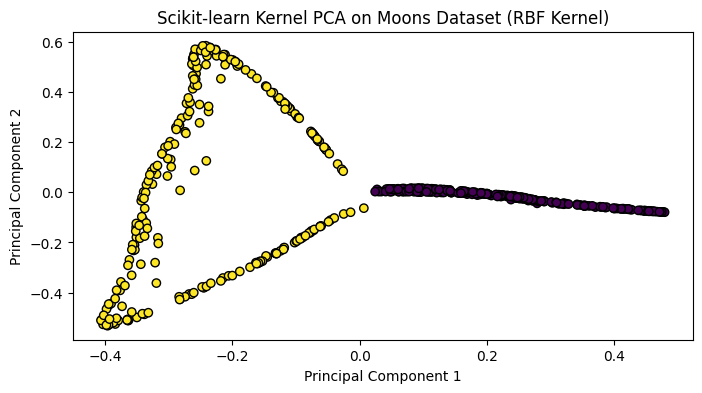

In [6]:
# Apply scikit-learn's Kernel PCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
Y_sklearn = kpca.fit_transform(X.T)

# Plot
plt.figure(figsize=(8, 4))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],
            c=y, cmap='viridis', edgecolor='k')
plt.title("Scikit-learn Kernel PCA on Moons Dataset (RBF Kernel)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()